### Data Preprocessing

In [1]:
from preprocessing import load_mcc5thu_data

state_list = [
    'health',
    'gear_pitting',
    'gear_wear',
    'miss_teeth',
    'teeth_break_and_bearing_inner',
    'teeth_break_and_bearing_outer',
    'teeth_break',
    'teeth_crack'
]

data_dir = r'\\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU'
#data_dir = './data'

# Window size를 통해 데이터 길이 조절 가능 (Non-stationary 감안해서 너무 길면 위험)
# speed choice에 따라 속도 분포가 다름 > 해당 깃허브 참고(https://github.com/liuzy0708/MCC5-THU-Gearbox-Benchmark-Datasets)

X_data, Y_data, D_data = load_mcc5thu_data(
    data_dir=data_dir,
    state_list=state_list,
    window_size=2000,
    num_samples=500,
    rpm_range=(1500, 2500),
    time_range=(0, 10),
    signal_col=['gearbox_vibration_x', 'gearbox_vibration_y', 'gearbox_vibration_z'],
    fault_level='H',
    mode_name='speed',
    torque_choice='20Nm',
    speed_choice='3000rpm'
)


[0] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\health_speed_circulation_20Nm-3000rpm.csv
[1] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\gear_pitting_H_speed_circulation_20Nm-3000rpm.csv
[2] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\gear_wear_H_speed_circulation_20Nm-3000rpm.csv
[3] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\miss_teeth_speed_circulation_20Nm-3000rpm.csv
[4] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\teeth_break_and_bearing_inner_H_speed_circulation_20Nm-3000rpm.csv
[5] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\teeth_break_and_bearing_outer_H_speed_circulation_20Nm-3000rpm.csv
[6] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\teeth_break_H_speed_circulation_20Nm-3000rpm.csv
[7] Loading: \\147.47.239.145\shrm\06. 장비 및 데이터 관리\1. 데이터 모음\Gear\MCC5-THU\teeth_crack_H_speed_circulation_

In [2]:
print(X_data.shape, Y_data.shape, D_data.shape)
# X_data: 4000개, 3축, 각 센서별 데이터
# Y_data: 8개 class: 0~7
# Z_data: 평균 주파수 -> train/test split

(4000, 3, 2000) (4000,) (4000,)


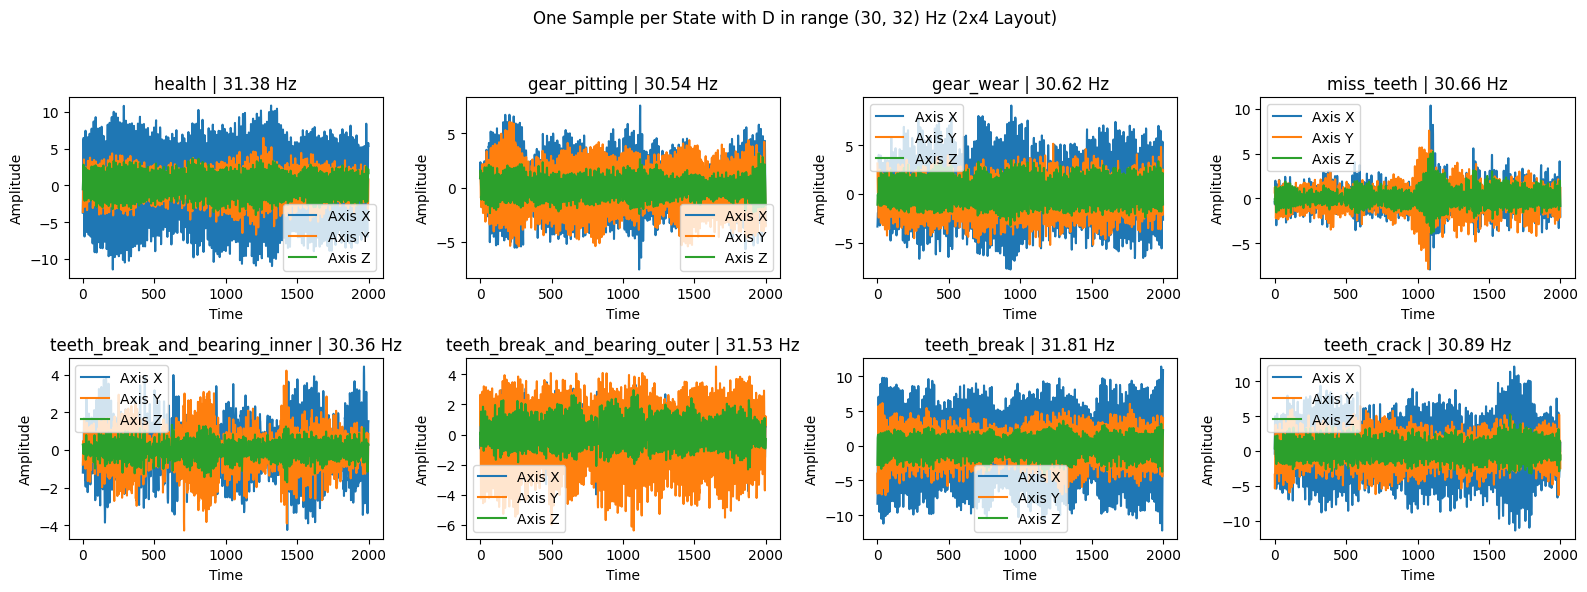

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the desired range of D_data (30 ~ 32)
D_range = (30, 32)
mask = (D_data >= D_range[0]) & (D_data <= D_range[1])

# Filter data within the range
filtered_indices = np.where(mask)[0]
filtered_X = X_data[filtered_indices]
filtered_Y = Y_data[filtered_indices]
filtered_D = D_data[filtered_indices]

# Initialize a list to store one sample index for each state (0 to 7)
selected_indices_per_state = []

for state in range(8):  # 0 to 7 (matching state_list)
    state_indices = np.where(filtered_Y == state)[0]
    if len(state_indices) > 0:
        # Randomly select one index for each state
        selected_indices_per_state.append(np.random.choice(state_indices, 1)[0])

# Ensure we have exactly 8 samples (one for each state)
if len(selected_indices_per_state) < 8:
    print("Not enough samples for each state in the specified range.")

# Plotting in a 2x4 layout (2 rows, 4 columns)
fig, axs = plt.subplots(2, 4, figsize=(16, 6))
fig.suptitle(f'One Sample per State with D in range {D_range} Hz (2x4 Layout)')

for i, idx in enumerate(selected_indices_per_state):
    row = i // 4
    col = i % 4
    axs[row, col].plot(filtered_X[idx, 0, :], label='Axis X')
    axs[row, col].plot(filtered_X[idx, 1, :], label='Axis Y')
    axs[row, col].plot(filtered_X[idx, 2, :], label='Axis Z')
    axs[row, col].set_title(f'{state_list[filtered_Y[idx]]} | {filtered_D[idx]:.2f} Hz')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Amplitude')
    axs[row, col].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



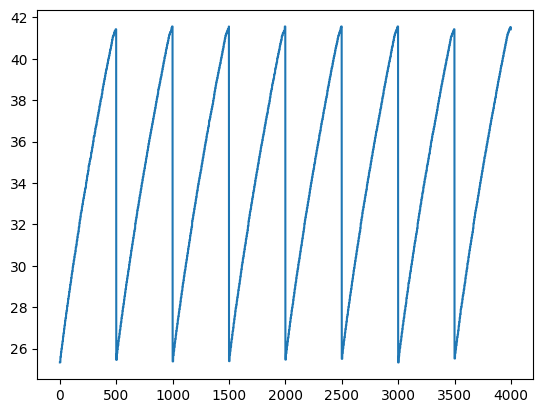

In [4]:
# 속도 분포포
plt.plot(D_data)
plt.show()

### Task

In [5]:
# import
import torch
import numpy as np
import torch.nn as nn

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import argparse

In [6]:
# 속도 분포에 따른 데이터 분류 40Hz 이상을 테스트 데이터로 설정

# Defining the threshold for speed (frequency) to separate train and test data
threshold_frequency = 40  # Hz

# Creating masks for training and test data based on the threshold
train_mask = D_data < threshold_frequency
test_mask = D_data >= threshold_frequency

# Filtering the data using the masks
X_train = X_data[train_mask]
Y_train = Y_data[train_mask]
D_train = D_data[train_mask]

X_test = X_data[test_mask]
Y_test = Y_data[test_mask]
D_test = D_data[test_mask]

# Displaying the shape of the filtered train and test sets
(X_train.shape, Y_train.shape, D_train.shape), (X_test.shape, Y_test.shape, D_test.shape)

(((3428, 3, 2000), (3428,), (3428,)), ((572, 3, 2000), (572,), (572,)))

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [8]:
parser = argparse.ArgumentParser()

# 필요시 추가 (되도록이면 자주 사용되고 바꿀 파라미터들은 여기서 관리하세용)
# 파라미터 접근 방법 opt.lr -> 1e-4가 불러와짐
#parser.add_argument('--epochs',type=int, default=50, help='epoch')
parser.add_argument('--epochs',type=int, default=5, help='epoch')
parser.add_argument('--lr',type=float, default=1e-4, help='learning rate')

parser.add_argument('--lamda',type=float, default=0.97, help='schedular Lamda')
parser.add_argument('--early_stop',type=int, default=20, help='early stop_patience')

parser.add_argument('--train_size',type=float, default=0.8, help='data split/valid_size=1-x')
parser.add_argument('--batch_size',type=int, default=8, help='batch size')

opt = parser.parse_args('')

In [9]:

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()  # Shape: (N, 3, 2000)
Y_train_tensor = torch.from_numpy(Y_train).long()   # Shape: (N,)

X_valid_tensor = torch.from_numpy(X_valid).float()
Y_valid_tensor = torch.from_numpy(Y_valid).long()

X_test_tensor = torch.from_numpy(X_test).float()
Y_test_tensor = torch.from_numpy(Y_test).long()

# Defining the custom dataset class
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, ix):
        x = self.x[ix].transpose(0, 1) # (3, 2000) -> (2000, 3) = (T, C)
        y = self.y[ix]
        return x.to(device).float(), y.to(device).long()

# Creating Dataset instances
train_dataset = MyDataset(X_train_tensor, Y_train_tensor)
valid_dataset = MyDataset(X_valid_tensor, Y_valid_tensor)
test_dataset = MyDataset(X_test_tensor, Y_test_tensor)

# Creating DataLoader instances
train_dl = DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=opt.batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=opt.batch_size, shuffle=False)


In [10]:
opt.src_vocab_size = 1         # dummy
opt.trg_vocab_size = 1         # dummy
opt.src_pad_idx = None         # 마스크 안 씀
opt.trg_pad_idx = None         # 마스크 안 씀
opt.proj_share_weight = False
opt.embs_share_weight = False
opt.d_model = 128  
opt.d_word_vec = 128
opt.d_inner_hid = 512
opt.n_layers = 4
opt.n_head = 4
opt.d_k = 32
opt.d_v = 32
opt.dropout = 0.1
opt.scale_emb_or_prj = 'none'
opt.lr_mul = 1.0
opt.n_warmup_steps = 4000

In [ ]:
from transformer.Layers import EncoderLayer

class CustomTransformerEncoder(nn.Module):
    def __init__(self, opt):
        super().__init__() # 부모 class 초기화
        self.input_proj = nn.Linear(3, opt.d_model) # 3(channel) -> d_model
        self.layers = nn.ModuleList([
            EncoderLayer(opt.d_model, opt.d_inner_hid, opt.n_head, opt.d_k, opt.d_v, dropout=opt.dropout)
            for _ in range(opt.n_layers)
        ])
        self.norm = nn.LayerNorm(opt.d_model, eps=1e-6)

    def forward(self, x):
        # x: (B, T, C=3)
        x = self.input_proj(x)
        for layer in self.layers:
            x, _ = layer(x)
        return self.norm(x)

class TransformerClassifier(nn.Module):
    def __init__(self, opt, num_classes=8):
        super().__init__()
        self.encoder = CustomTransformerEncoder(opt)
        self.classifier = nn.Linear(opt.d_model, num_classes) # d_model -> num_classes

    def forward(self, x):
        x = self.encoder(x)        # (B, T, d_model)
        x = x.mean(dim=1)          # average pooling #2번째 차원 mean
        return self.classifier(x)  # (B, num_classes)

model = TransformerClassifier(opt).to(device)

In [21]:
from tqdm.notebook import tqdm
import pickle

def train(opt, train_dl, valid_dl):
    
    dict_result = {'train_loss': [],
                   'valid_loss': [],
                   'stop_point': 0
                    }
    
    best_loss = 10000
    early_stopping_count = 0
    
    #model = model.to(device)
    loss_cross = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(list(model.parameters()), lr=opt.lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: opt.lamda ** epoch)
    model.load_state_dict(torch.load('./output/model_weights.pth'))
    
    pbar = tqdm(range(opt.epochs), unit = 'epoch')
    
    for epoch in pbar:
        iter_loss = []
        iter_valid_loss = []
        
        # Training Model
        model.train()
        for ix, batch in enumerate(iter(train_dl)):
            x, y = batch
            pred = model(x)
            loss_y = loss_cross(pred, y)

            batch_loss = loss_y
            
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
            iter_loss.append(batch_loss.item())
            
            pbar.set_postfix({'train_loss' : loss_y.item()})

        scheduler.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            
            for ix, batch in enumerate(iter(valid_dl)):
                v_x, v_y = batch
                v_pred = model(v_x)
                v_loss_y = loss_cross(v_pred, v_y)
                
                iter_valid_loss.append(v_loss_y.item())

        epoch_train = np.mean(iter_loss)
        epoch_valid = np.mean(iter_valid_loss)

        print( ' Epoch: {} / train_loss: {:.4f} / valid_loss: {:.4f}'.format(epoch+1, epoch_train, epoch_valid))
            
        ##################### result_save ############################           
        dict_result['train_loss'].append(epoch_train)
        dict_result['valid_loss'].append(epoch_valid)
        ###############################################################
            
        if epoch_valid < best_loss:
            best_model = model
            early_stopping_count = 0
            dict_result['stop_point'] = epoch+1
            print( ' >>> Best model save ! '.format(epoch+1, epoch_valid))
            
            best_loss = epoch_valid

        else:
            early_stopping_count = early_stopping_count + 1

        if early_stopping_count > opt.early_stop:
            break
        
    return best_model

In [13]:
model = train(opt, train_dl, valid_dl) # 1~5회 

  0%|          | 0/5 [00:00<?, ?epoch/s]

 Epoch: 1 / train_loss: 1.6852 / valid_loss: 1.0866
 >>> Best model save ! 
 Epoch: 2 / train_loss: 0.9209 / valid_loss: 0.8317
 >>> Best model save ! 
 Epoch: 3 / train_loss: 0.6647 / valid_loss: 0.5548
 >>> Best model save ! 
 Epoch: 4 / train_loss: 0.4936 / valid_loss: 0.4611
 >>> Best model save ! 
 Epoch: 5 / train_loss: 0.3917 / valid_loss: 0.3111
 >>> Best model save ! 


In [22]:
model = train(opt, train_dl, valid_dl) # 6~10회

C:\Users\limuri\AppData\Local\Temp\ipykernel_11272\2661792097.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./output/model_weights.p

  0%|          | 0/5 [00:00<?, ?epoch/s]

 Epoch: 1 / train_loss: 0.3266 / valid_loss: 0.2602
 >>> Best model save ! 
 Epoch: 2 / train_loss: 0.2359 / valid_loss: 0.1975
 >>> Best model save ! 
 Epoch: 3 / train_loss: 0.2090 / valid_loss: 0.3179
 Epoch: 4 / train_loss: 0.1429 / valid_loss: 0.1269
 >>> Best model save ! 
 Epoch: 5 / train_loss: 0.1568 / valid_loss: 0.0906
 >>> Best model save ! 


In [23]:
torch.save(model.state_dict(), './output/model_weights-2.pth')
torch.save(model, './output/full_model-2.pth')


In [24]:
def result(test_dl, model):
    
    pred = []
    y = []
    total = 0
    
    model.eval()
    with torch.no_grad():
        for ix, batch in enumerate(iter(test_dl)):
            t_x, t_y = batch
            t_pred = model(t_x)

            pred.extend(torch.argmax(t_pred, 1).cpu().numpy())
            y.extend(t_y.cpu().numpy())
            
            total = total + len(batch[0])
            
    pred = np.array(pred)
    y = np.array(y)
    
    acc = sum(pred==y) / total * 100
    
    return acc

In [25]:
acc = result(test_dl, model)

print(f"Test Accuracy: {acc:.2f}%")

Test Accuracy: 63.99%


In [ ]:
#from numba import cuda
#device = cuda.get_current_device(); device.reset()